## Susannah D'Arcy 
# Do Articles about Elon Musk affect Tesla Stocks?

For this notebook I have decided to see if there was a correlation between the amount of articles written about Elon Musk, and the stock price of Tesla.

To gather this information I have used 2 API's, World Trading Data API and New York Time's Article Search API

In [23]:
import requests
import csv
from datetime import date, timedelta
import time
import calendar
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import pearsonr


## Collecting from First API: World Trading Data API

World Trading Data API : https://www.worldtradingdata.com/home
Stocks collected using World Trading Data API, with a free account. Which allowed 250 calls to their API a day.

WTD API allows me to gather all the stock values of a given stock from a start date to an end date. Which means I only require one call/query to collect all of my data.

In [123]:
#Function calls API with specified start date and end date. Returns a JSON
def getStock(dateStart, dateEnd):
   querystring = {
    "symbol":"TSLA",
    "api_token":"SECRET",
    "date_from": dateStart,
    "date_to":dateEnd,
    "sort":"newest",
    "output":"json"
    }
   url = "https://api.worldtradingdata.com/api/v1/history"
   response = requests.request("GET", url, params=querystring)
   data = response.json() 
   return data['history']

startDate = "2018-01-01"
endDate = "2019-06-01"
# Write to .csv our api data
with open('stock.csv', 'wt') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    # first row to describe attributes
    filewriter.writerow(['date', 'open', 'close'])
    data = getStock(startDate, endDate)
    #Our response from our query returns a dictonary with the date as the key, and the info as its value.
    for key, value in data.items(): 
        filewriter.writerow([key, value['open'], value['close']])

## Collecting from Second API: New York Time Search API

New York Time Search API : https://developer.nytimes.com/docs/articlesearch-product/1/overview

NYT Search API is a free service in which I have an account which can call 4,000 requests per day and 10 requests per minute.

NYT Search API allows me to search for all articles with certain words in their articles. I can filter which dates I want to observe.

I record the type_of_material information, as it shows the type of article. Some articles are mentioned twice as they are recorded for their article and a summary article called 'briefing' which had the headlines for that day. These will later be filtered out.

In [ ]:
def getArticles(query, date):
    querystring = {
        "q":query,
        "fq": "pub_date:(" + date + ")",
        "api-key": "SECRET"     
    }
  
    url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"
    response = requests.request("GET", url, params=querystring)
    data = response.json()
    parsed = [];
    for d in data["response"]["docs"]:
        #There is one article, which does not have a type_of_material recorded, Its an China Daily article that paid NYT to post.
        if d["_id"] == "nyt://paidpost/a054f880-fa2d-5858-8dd5-9f01562bc232":
             parsed.append([d["_id"], date, "Advertisement"])
        else:
            parsed.append([d["_id"], date, d["type_of_material"]])
    toReturn = [date, parsed, data["response"]["meta"]["hits"]]
    return toReturn

#Dates:
startDate = date(2018, 1, 1) #"2018-01-01"
endDate = date(2019, 6, 1) #"2019-06-01"

delta = endDate - startDate

'''
We have 2 Articles: 
articles.csv repersents all the different articles.
articlesCount.csv repersents the amount of articles per day
'''
# Write to .csv our api data
with open('articles.csv', 'wt') as csvfileArticles, open('articlesCount.csv', 'wt') as csvfileArticlesCount:
     # csv file 1
    filewriter = csv.writer(csvfileArticles, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['id', 'date', 'type'])
    # csv file 2
    countfilewriter = csv.writer(csvfileArticlesCount, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    countfilewriter.writerow(['date', 'count'])
    #For everyday between our start and end date
    for i in range(delta.days + 1):
        day = startDate + timedelta(days=i)
        #calls API with date, and search term Elon Musk
        data = getArticles("Elon Musk", str(day))
        #Data[0] is our date, data[1] is our list of articles. Data[2] is our article count
        for d in data[1]:
            filewriter.writerow([d[0], d[1], d[2]])
        countfilewriter.writerow([data[0], data[2]])
        #Need to wait 6 seconds between each call for our 10 calls per minitue limit.
        time.sleep(6)    


## Cleaning Articles

The API record duplicate articles when an article is mentioned in a briefing article. Which means our article count is wrong. We therefore have to remove all briefing articles, and update the article count.

Also in this cleaning step I remove any possible duplicate headers, or rows (by article id)

In [26]:
with open('articlesClean.csv', 'wt') as csvfile, open('articlesCountClean.csv', 'wt') as csvfileCount:
    filewriter = csv.writer(csvfile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['id', 'date', 'type'])
    df = pd.read_csv('articles.csv', delimiter=';')
    
    filewriterCount = csv.writer(csvfileCount, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriterCount.writerow(['date', 'count'])
    dfCount = pd.read_csv('articlesCount.csv', delimiter=';')
    
    deleted = {}
    ids = {}
    
    for index, row in df.iterrows():
        if row['date'] not in deleted:
             deleted[row['date']] = 0
        if row['type'] == 'briefing':
            deleted[row['date']] += 1
        elif row['id'] == 'id'  and row['date'] == 'date' and row['type'] == 'type':
            continue
        elif row['id'] in ids:
            continue
        else:
            ids[row['id']] = 1
            filewriter.writerow([row['id'], row['date'], row['type']])
    for index, row in dfCount.iterrows():
        if row['date'] in deleted:
            filewriterCount.writerow([row['date'], (row['count'] - deleted[row['date']]) ])
        else:
            filewriterCount.writerow([row['date'], row['count']])

dfClean = pd.read_csv('articlesClean.csv', delimiter=';')
dfCountClean = pd.read_csv('articlesCountClean.csv', delimiter=';')

In [27]:
#Old Article Files
df.head()

,id,date,type
0,nyt://article/74237053-99b5-5c5d-8e8a-1bdeac44...,2018-01-01,News
1,nyt://article/d497c1e0-fd51-5ba8-85c0-4aa67762...,2018-01-01,Review
2,nyt://article/e0aec009-35be-5705-9c93-e0b58450...,2018-01-01,briefing
3,nyt://article/bb3bbfea-c76a-5f2c-b846-62c08284...,2018-01-02,News
4,nyt://article/80edcc27-a3d9-5371-b7ec-a2a53af6...,2018-01-02,Schedule


In [28]:
df.count()

id      633
date    633
type    633
dtype: int64

In [29]:
dfCount.head()

,date,count
0,2018-01-01,3
1,2018-01-02,5
2,2018-01-03,1
3,2018-01-04,3
4,2018-01-05,0


In [30]:
#New Cleaned Article Files.
dfNew = pd.read_csv('articlesClean.csv', delimiter=';')
dfNewCount = pd.read_csv('articlesCountClean.csv', delimiter=';')
dfNew.head()

,id,date,type
0,nyt://article/74237053-99b5-5c5d-8e8a-1bdeac44...,2018-01-01,News
1,nyt://article/d497c1e0-fd51-5ba8-85c0-4aa67762...,2018-01-01,Review
2,nyt://article/bb3bbfea-c76a-5f2c-b846-62c08284...,2018-01-02,News
3,nyt://article/80edcc27-a3d9-5371-b7ec-a2a53af6...,2018-01-02,Schedule
4,nyt://article/1a677bfb-c0fb-5e93-b00e-7211749a...,2018-01-02,News


In [31]:
dfNew.count()

id      478
date    478
type    478
dtype: int64

In [32]:
dfNewCount.head()

,date,count
0,2018-01-01,2
1,2018-01-02,4
2,2018-01-03,1
3,2018-01-04,3
4,2018-01-05,0


From these comparisons we can see that have removed breifings, updated the count, and removed duplicates

## Cleaning Stock

The API doesnt record the stock values on the weekends (as the stock market is closed), which means I have missing values in my stock data set. To fix this I decided to use an average of the previous possible dates stock value and the next possible dates stock value.

In this stage I also made sure all of the values for to 2.d.p and generated a diff and diffAbs row. These repersented the difference and absoulte difference of the stock value in each day.

In [33]:
with open('stockClean.csv', 'wt') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['date', 'open', 'close', 'diff', 'diffAbs'])
    
    dfArticle = pd.read_csv('articlesCountClean.csv', delimiter=';')
    dfStock = pd.read_csv('stock.csv', delimiter=';')
    #Having the Date as in index is needed to find the value per a specific date
    dfStock2 = dfStock.set_index('date', drop = False)
    
    #Find Missing Dates from Stocks based on Article's dates
    missingDates = []
    for index, row in dfArticle.iterrows():
        if row['date'] not in dfStock.date.values:
            missingDates.append(row['date'])
            
    #Update the missing dates with their new values        
    dates = []
    for d in missingDates:
        #The start and end of our search just happened to be a missing value
        #We can't update this as we haven't recorded the necessary infomation, therefore we skip, and never add it into our new dataset 
        if d != '2018-01-01' and d != '2019-06-01':
            #Convert Date into DateTime format
            datetime = date(*map(int, d.split('-')))
            startDate = datetime    #startDate: previous possible date
            endDate = datetime      #endDate: next possible date
            while str(startDate) not in dfStock.date.values:
                startDate = startDate - timedelta(days=1)
            while str(endDate) not in dfStock.date.values:
                endDate = endDate + timedelta(days=1)
            #Find average values 
            avgOpen = (dfStock2.loc[str(startDate), 'open'] + dfStock2.loc[ str(endDate), 'open'])/2
            avgClose = (dfStock2.loc[str(startDate), 'close'] + dfStock2.loc[ str(endDate), 'close'])/2
            dates.append([d, avgOpen, avgClose])
    
    #Create new dataframe of missing dates with average values
    dfMissing = pd.DataFrame(dates, columns=['date', 'open', 'close'])
    #Append missing values to stock dataframe, and sort by date
    dfStockClean = dfStock.append(dfMissing)
    dfStockClean.sort_values(by='date', inplace=True, ascending=True)
    #Round to 2.dp
    dfStockClean['open'] = dfStockClean['open'].astype(float).round(2)
    dfStockClean['close'] = dfStockClean['close'].astype(float).round(2)
    #Create new columns Diff and DiffAbs and round to 2.dp
    dfStockClean['diff'] = (dfStockClean['close'] - dfStockClean['open']).astype(float).round(2)
    dfStockClean['diffAbs'] = (abs(dfStockClean['diff'])).astype(float).round(2)
    #Write new data frame to file
    for index, row in dfStockClean.iterrows():
        filewriter.writerow([row['date'], row['open'], row['close'], row['diff'], row['diffAbs']])

In [34]:
#Old Stock Files
dfStock.sort_values(by='date', inplace=True, ascending=True)
dfStock.head()

,date,open,close
354,2018-01-02,312.00,320.53
353,2018-01-03,321.00,317.25
352,2018-01-04,312.87,314.62
351,2018-01-05,316.62,316.58
350,2018-01-08,316.00,336.41


In [35]:
dfStock.count()

date     355
open     355
close    355
dtype: int64

In [36]:
#New Cleaned Stock Files.
dfNewStock = pd.read_csv('stockClean.csv', delimiter=';')
dfNewStock.head()

,date,open,close,diff,diffAbs
0,2018-01-02,312.00,320.53,8.53,8.53
1,2018-01-03,321.00,317.25,-3.75,3.75
2,2018-01-04,312.87,314.62,1.75,1.75
3,2018-01-05,316.62,316.58,-0.04,0.04
4,2018-01-06,316.31,326.50,10.19,10.19


In [37]:
dfNewStock.count()

date       515
open       515
close      515
diff       515
diffAbs    515
dtype: int64

From comparing the new stock and old stock files we can see that I have added the missing dates.

## Summary of Stock and Article Count
Here is a visual summary of my 2 datasets.

In [38]:
dfArticlesCount = pd.read_csv('articlesCountClean.csv', delimiter=';')
dfStock = pd.read_csv('stockClean.csv', delimiter=';')

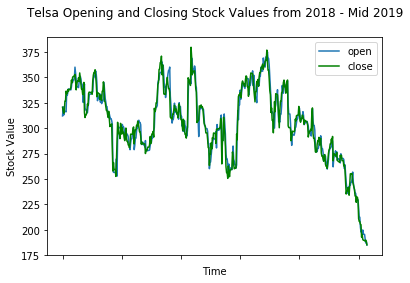

In [39]:
ax = plt.gca()
dfStock.plot(kind='line', x='date', y='open', ax=ax)
dfStock.plot(kind='line', x='date', y='close', color='green', ax=ax)
plt.title("Telsa Opening and Closing Stock Values from 2018 - Mid 2019\n")
plt.ylabel("Stock Value")
plt.xlabel("Time")
plt.show()

<Figure size 432x288 with 0 Axes>

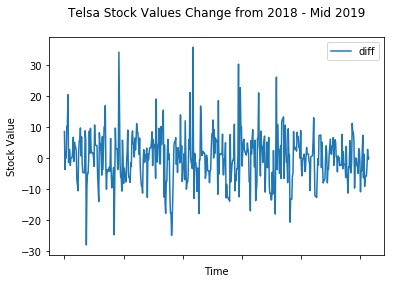

In [40]:
plt.figure()
dfStock.plot(kind='line', x='date', y='diff')
plt.title("Telsa Stock Values Change from 2018 - Mid 2019\n")
plt.ylabel("Stock Value")
plt.xlabel("Time")
plt.show()

<Figure size 432x288 with 0 Axes>

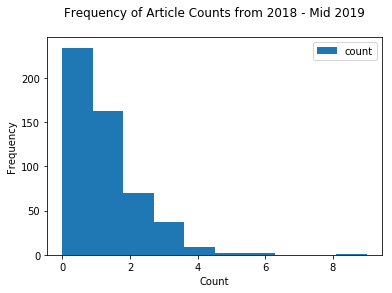

In [41]:
plt.figure()
dfArticlesCount.plot.hist(stacked=True)
plt.title("Frequency of Article Counts from 2018 - Mid 2019\n")
plt.xlabel("Count")
plt.show()

<Figure size 432x288 with 0 Axes>

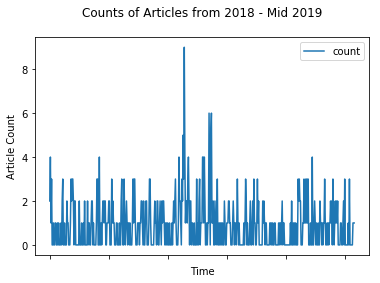

In [42]:
plt.figure()
dfArticlesCount.plot('date','count')
plt.title("Counts of Articles from 2018 - Mid 2019\n")
plt.ylabel("Article Count")
plt.xlabel("Time")
plt.show()

## Merging Articles and Stocks

I merged articlesCount and stocks to repersent for each day the stock values and the amount of articles.

In [43]:
dfArticles = pd.read_csv('articlesCountClean.csv', delimiter=';')
dfStock = pd.read_csv('stockClean.csv', delimiter=';')
mergedf = pd.merge(dfArticles, dfStock[['date', 'open', 'close', 'diff', 'diffAbs']], on='date')

## Smooth Data set

Noticed in the graphs above, due to that the data is for each data, the graph isn't very readable.
To fix this I averaged the data for each week, which means we will have a smoother graph and smaller data set.

To show the difference in each week, I compared the closing stock value for each week.

In [44]:
#To keep track of weeks
weekDayCount = {
    "Monday": 0,
    "Tuesday": 0,
    "Wednesday": 0,
    "Thursday": 0,
    "Friday": 0,
    "Saturday":0,
    "Sunday":0
}
weeklyAverage = []
weeklyCount = []
weeklyClose = []
for index, row in mergedf.iterrows():
    d = row['date']
    #Convert Date column into DateTime format
    d = date(*map(int, d.split('-')))
    day = calendar.day_name[d.weekday()]
    weekDayCount[day] += 1
    #If count = 2 we have passed into the next week
    if weekDayCount[day] == 2:
        #Calulate weekly averages, and round up count
        weeklyAverage.append([row['date'], math.ceil(sum(weeklyCount)/len(weeklyCount)), sum(weeklyClose)/len(weeklyClose)])
        #Refreash lists and Dict for the next week.
        for day in weekDayCount:
            weekDayCount[day] = 0
        weeklyCount = []
        weeklyClose = []
        #Add this date as the start of the week
        weeklyCount.append(row['count'])
        weeklyClose.append(row['close']) 
    else:
        weeklyCount.append(row['count'])
        weeklyClose.append(row['close'])
        
#Create New Date frame for weekly values
weeklydf = pd.DataFrame(weeklyAverage, columns = ['Week', 'Average Count', 'Average Close'])
weeklydf['Average Close'] = weeklydf['Average Close'].astype(float).round(2) 

#Calcluate average weekly difference
weeklyDiff = []
weeklyDiffAbs = []
for i in range(len(weeklydf.index) - 1):
    diff = (weeklydf.iloc[i + 1]['Average Close'] - weeklydf.iloc[i]['Average Close'])
    weeklyDiff.append(diff)
    weeklyDiffAbs.append(abs(diff))
#Last Value has no change in week.
weeklyDiff.append(0)
weeklyDiffAbs.append(0)
weeklydf['Average Diff'] = weeklyDiff
weeklydf['Average AbsDiff'] = weeklyDiffAbs

## Analyse



### Descriptive Statistics
Our intial data with daily statistics

In [45]:
print("Daily Data Set Descriptive Stats:\n")
print(mergedf.describe())

Daily Data Set Descriptive Stats:

            count        open       close        diff     diffAbs
count  515.000000  515.000000  515.000000  515.000000  515.000000
mean     0.926214  305.392078  305.250951   -0.141126    5.791650
std      1.146129   36.461770   36.848306    7.760557    5.161175
min      0.000000  185.100000  185.160000  -28.080000    0.020000
25%      0.000000  283.395000  284.520000   -4.770000    2.205000
50%      1.000000  307.000000  306.850000    0.220000    4.500000
75%      1.000000  334.735000  335.095000    4.150000    7.900000
max      9.000000  375.000000  379.570000   35.730000   35.730000


In [46]:
print("Weekly Data Set Descriptive Stats:\n")
print(weeklydf.describe())

Weekly Data Set Descriptive Stats:

       Average Count  Average Close  Average Diff  Average AbsDiff
count      64.000000      64.000000     64.000000        64.000000
mean        1.343750     306.200938     -1.997656        13.644844
std         0.622814      34.300922     18.296893        12.234919
min         0.000000     194.780000    -44.990000         0.000000
25%         1.000000     284.320000    -14.397500         4.365000
50%         1.000000     307.150000     -2.280000        11.190000
75%         2.000000     334.090000      9.057500        19.335000
max         4.000000     361.110000     56.720000        56.720000


Our mean and medians are close in value in our weekly data set which means that by averaging each week we have removed possible outliers.

### Scatter Plots
Our main goal is to see if article count effects stock price change. We can use scatter plot to plot diff to count to see a possible patterns and outliers.

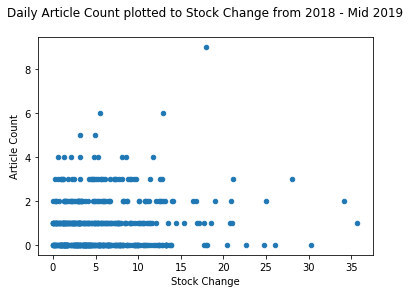

In [47]:
ax = plt.gca()
mergedf.plot(kind='scatter', x='diffAbs', y='count', ax=ax)
plt.title("Daily Article Count plotted to Stock Change from 2018 - Mid 2019\n")
plt.ylabel("Article Count")
plt.xlabel("Stock Change")
plt.show()

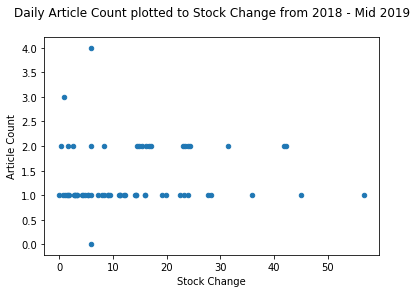

In [48]:
ax = plt.gca()
weeklydf.plot(kind='scatter', x='Average AbsDiff', y='Average Count', ax=ax)
plt.title("Daily Article Count plotted to Stock Change from 2018 - Mid 2019\n")
plt.ylabel("Article Count")
plt.xlabel("Stock Change")
plt.show()

### Pearsons correlation
Pearsons correlation is a number between -1 and 1 that indicates the extent to which two variables are linearly related.

Our Weak Positive Correlation shows that the amount of articles on Elon Musk does positively effect the change of Telsa stock price. However our connection is weak, which means that this study is not enough to proof a linear relationship. This could be due to the fact that we only counted NYT articles.

In [49]:
corr, _ = (pearsonr(weeklydf['Average Count'], weeklydf['Average AbsDiff']))
print('Pearsons correlation: %.3f' % corr)
print('Weak Postive Correlation')

Pearsons correlation: 0.076
Weak Postive Correlation


### Line Graphs
Shows the variance in data.
Also if we compare the graphs for our daily data set we have smoothed out each graph, and made the graphs easier to understand.

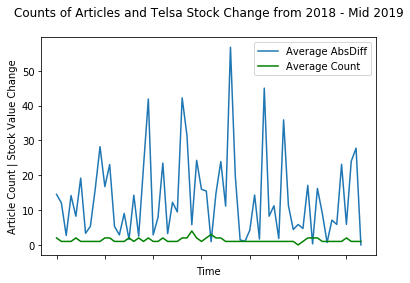

In [50]:
ax = plt.gca()
weeklydf.plot(kind='line', x='Week', y='Average AbsDiff', ax=ax)
weeklydf.plot(kind='line', x='Week', y='Average Count', color='green', ax=ax)
plt.title("Counts of Articles and Telsa Stock Change from 2018 - Mid 2019\n")
plt.ylabel("Article Count | Stock Value Change")
plt.xlabel("Time")
plt.show()

Count has little variance, while the difference of each stock value jumps by a lot each week. This shows that the stock values of Telsa are unstable, and not strongly connected to count of Elon Musk Articles

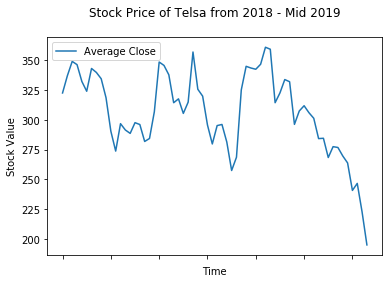

In [51]:
ax = plt.gca()
weeklydf.plot(kind='line', x='Week', y='Average Close', ax=ax)
plt.title("Stock Price of Telsa from 2018 - Mid 2019\n")
plt.ylabel("Stock Value")
plt.xlabel("Time")
plt.show()

The price of Telsa has grealty decrease throughout the year. This could be due to the Elon Musk twitter controversy

### Stack Histogram
Shows that all of our counts are below 5, and a majority of our differences are between 0 and 30 

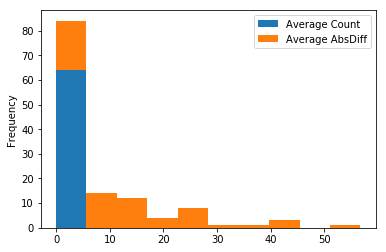

In [52]:
histdf = weeklydf.drop(columns = ['Average Close', 'Average Diff'])
histdf.plot.hist(stacked=True)

### Further Comparison into the relationship between count and diff

To represent the effect that the count of articles and the change in stock price, I will group my dataset by count, and compare the averages.

               Average Diff  Average AbsDiff
Average Count                               
0                 -5.860000         5.860000
1                 -1.983488        12.492791
2                 -1.768889        17.971111
3                  0.940000         0.940000
4                 -5.800000         5.800000


<Figure size 432x288 with 0 Axes>

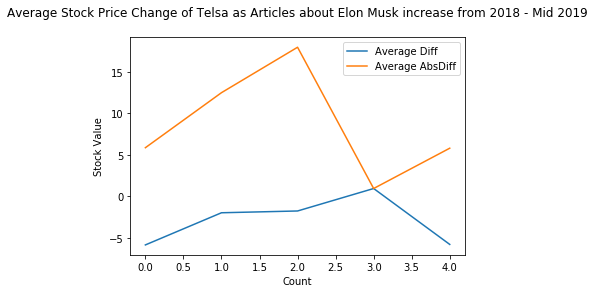

In [53]:
dfComparison = weeklydf.drop(columns=['Week', 'Average Close'])
dfComparison = dfComparison.groupby('Average Count')
temp_data = dfComparison.mean()
print(temp_data.head())

plt.figure()
dfComparison.mean().plot()
plt.title("Average Stock Price Change of Telsa as Articles about Elon Musk increase from 2018 - Mid 2019\n")
plt.ylabel("Stock Value")
plt.xlabel("Count")
plt.show()

From this graph we can see that the optimal amount of articles to change the stock price is 2. After 2 the effect is lessened.

                 Average Count
Average AbsDiff               
0.00                         1
0.29                         2
0.70                         1
0.94                         3
1.04                         1


<Figure size 432x288 with 0 Axes>

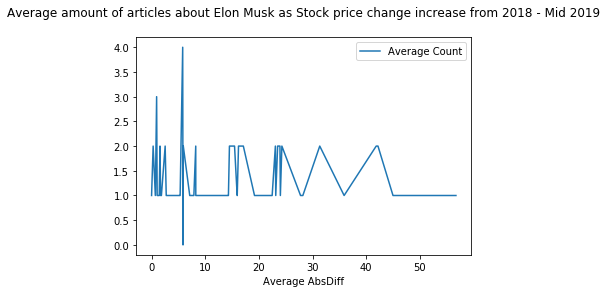

In [54]:
dfComparison = weeklydf.drop(columns=['Week', 'Average Close', 'Average Diff'])
dfComparison = dfComparison.groupby('Average AbsDiff')
temp_data = dfComparison.mean()
print(temp_data.head())

plt.figure()
dfComparison.mean().plot()
plt.title("Average amount of articles about Elon Musk as Stock price change increase from 2018 - Mid 2019\n")
plt.show()

From this graph the article count fluctuates as average absolute  stock change increases. Which suggests no strong relationship

## Conclusion
From these results we are unable to determine a strong relationship between Elon Musk articles and his Telsa stock price. This is due to the short scope of our article search as NYT search API only searched for NYT articles. Perhaps with further studies with a new API we can correctly determine if there is a relationship. Also to improve the article searches we could include other key terms such as Tesla. We could also continue the research into studying Elon Musk's other assets.